# Full Fine-Tuning

In [ ]:
!pip install transformers datasets accelerate bitsandbytes bert-score --upgrade
!pip install -U bitsandbytes

In [2]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import load_dataset
import time


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from bert_score import score
from tqdm import tqdm

def compute_bertscore(model, dataset, tokenizer, sample_size=100):
    model.eval()
    predictions = []
    references = []
    indices = np.random.choice(len(dataset), min(sample_size, len(dataset)), replace=False)
    with torch.no_grad():
        for idx in tqdm(indices):
            item = dataset[int(idx)]
            full_text = tokenizer.decode(item["input_ids"], skip_special_tokens=True)
            if "Answer:" not in full_text:
                continue
            prompt = full_text.split("Answer:")[0] + "Answer:"
            reference = full_text.split("Answer:")[-1].strip()
            if not reference:
                continue
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id,
            )
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            prediction = generated_text[len(prompt):].strip()
            if prediction:
                predictions.append(prediction)
                references.append(reference)
    if predictions:
        P, R, F1 = score(predictions, references, lang="en", verbose=False)
        return {
            'precision': P.mean().item(),
            'recall': R.mean().item(),
            'f1': F1.mean().item()
        }
    return {'precision': 0, 'recall': 0, 'f1': 0}

def plot_training_and_bertscore(metrics_callback, bertscore_dicts, savepath='training_results.png'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Первый график ― лоссы
    axes[0].plot(metrics_callback.train_steps, metrics_callback.train_losses, label='Train Loss', marker='o')
    axes[0].plot(metrics_callback.eval_steps, metrics_callback.eval_losses, label='Validation Loss', marker='s')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Второй график ― столбцы по BERTScore
    models = [d['model'] for d in bertscore_dicts]
    precisions = [d['precision'] for d in bertscore_dicts]
    recalls = [d['recall'] for d in bertscore_dicts]
    f1s = [d['f1'] for d in bertscore_dicts]

    x = np.arange(len(models))
    width = 0.25

    axes[1].bar(x - width, precisions, width, label='Precision')
    axes[1].bar(x,        recalls,   width, label='Recall')
    axes[1].bar(x + width, f1s,      width, label='F1')
    axes[1].set_ylabel('Score')
    axes[1].set_title('BERTScore по моделям')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models)
    axes[1].legend()
    axes[1].set_ylim(0.7, 1.0)

    # Значения на столбцах
    for i, (p, r, f) in enumerate(zip(precisions, recalls, f1s)):
        axes[1].text(i-width, p+0.01, f'{p:.3f}', ha='center', va='bottom', fontsize=9)
        axes[1].text(i,       r+0.01, f'{r:.3f}', ha='center', va='bottom', fontsize=9)
        axes[1].text(i+width, f+0.01, f'{f:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"Графики сохранены в '{savepath}'")
    plt.show()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Callback для сохранения метрик
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.train_steps = []
        self.eval_steps = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.train_steps.append(state.global_step)
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                self.eval_steps.append(state.global_step)

# 1. Загрузка датасета MS MARCO
ds = load_dataset("microsoft/ms_marco", "v1.1", split="train[:1000]")

# 2. Предобработка
def preprocess(example):
    query = example["query"]
    
    # Извлекаем контекст из passages
    if "passages" in example and example["passages"]["passage_text"]:
        context = " ".join(example["passages"]["passage_text"][:1])
    else:
        context = ""
    
    # Извлекаем правильный ответ из поля 'answers'
    if "answers" in example and len(example["answers"]) > 0:
        answer = example["answers"][0]  # Берём первый ответ
    else:
        answer = ""  # Пропускаем примеры без ответа
    
    prompt = f"Question: {query}\nContext: {context}\nAnswer:"
    
    return {"prompt": prompt, "answer": answer}

# Фильтруем примеры без ответов
ds = ds.map(preprocess).filter(lambda x: x["answer"] != "")

ds = ds.map(preprocess)

# 3. Разделение на train/val/test: 70%/15%/15%
train_test_split = ds.train_test_split(test_size=0.3, seed=42)
val_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

train_ds = train_test_split["train"]
val_ds = val_test_split["train"]
test_ds = val_test_split["test"]

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

# 4. Токенизация
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B", trust_remote_code=True, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
max_length = 512

def tokenize(batch):
    inputs = []
    targets = []

    for prompt, answer in zip(batch["prompt"], batch["answer"]):
        full_text = prompt + " " + answer + tokenizer.eos_token
        inputs.append(full_text)
        targets.append(answer + tokenizer.eos_token)
    
    model_inputs = tokenizer(
        inputs,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors=None
    )
    
    # Маскируем промпт, оставляем только ответ для loss
    labels = []
    
    for i, (inp, tgt) in enumerate(zip(inputs, targets)):
        prompt_len = len(tokenizer(batch["prompt"][i])["input_ids"])
        label = model_inputs["input_ids"][i].copy()
        label = [-100 if token == tokenizer.pad_token_id else token for token in label]
        for i in range(min(max_length, prompt_len)):
            label[i] = -100
        labels.append(label[:max_length])
    
    model_inputs["labels"] = labels
    
    return model_inputs


train_ds = train_ds.map(tokenize, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(tokenize, batched=True, remove_columns=val_ds.column_names)
test_ds = test_ds.map(tokenize, batched=True, remove_columns=test_ds.column_names)

train_ds.set_format(type="torch")
val_ds.set_format(type="torch")
test_ds.set_format(type="torch")

# 5. Загрузка исходной модели для baseline
print("Evaluating baseline model...")
baseline_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-0.6B", 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16, 
    device_map="auto"
)

# Освобождаем память
del baseline_model
torch.cuda.empty_cache()

# 6. Загрузка модели для fine-tuning
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-0.6B", 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16, 
    device_map="auto"
)

# 7. Callback для метрик
metrics_callback = MetricsCallback()

# 8. Training arguments
training_args = TrainingArguments(
    output_dir="./outputs",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=4,
    gradient_accumulation_steps=8,
    optim="adamw_torch",
    learning_rate=2e-5,
    fp16=False,
    bf16=True,
    save_steps=100,
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=10,
    report_to=[],
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    callbacks=[metrics_callback],
)



README.md: 0.00B [00:00, ?B/s]

v1.1/validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

v1.1/train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

v1.1/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

Train size: 679, Val size: 145, Test size: 146


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

Evaluating baseline model...


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/tmp/ipykernel_126/1955459235.py:170: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


In [5]:

# 10. Обучение
print("Starting training...")
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Training time: {training_time:.2f} min.")
print(f"GPU VRAM used: {torch.cuda.max_memory_allocated() // (1024**2)} MB")

# 11. Сохранение модели
trainer.save_model("./finetuned_qwen_ms_marco")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Starting training...


Step,Training Loss,Validation Loss
10,2.812400,2.140853
20,1.950900,1.947823
30,2.116900,1.920284
40,2.259800,1.901096
50,1.866800,1.889181
60,1.831500,1.897392
70,1.698100,1.905079
80,1.880600,1.906804
90,1.659700,1.908321
100,1.559500,1.914692


Training time: 28.05 min.
GPU VRAM used: 9662 MB


In [6]:

full_fine_tuning_metrics = {
    **compute_bertscore(model, test_ds, tokenizer),
    "model": "full fine-tuning"
}

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
print("Evaluating baseline model...")
baseline_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-0.6B", 
    trust_remote_code=True, 
    torch_dtype=torch.bfloat16, 
    device_map="auto"
)

baseline_metrics = {
    **compute_bertscore(baseline_model, test_ds, tokenizer),
    "model": "baseline"
}
# Пример использования:

# bertscore_dicts = [
#    {"model": "Baseline", "precision": 0.82, "recall": 0.80, "f1": 0.81},
#    {"model": "Finetuned", "precision": 0.84, "recall": 0.83, "f1": 0.84},
#    {"model": "QLoRA", "precision": 0.85, "recall": 0.83, "f1": 0.84}
# ]
# plot_training_and_bertscore(metrics_callback, bertscore_dicts)

Evaluating baseline model...


100%|██████████| 100/100 [03:41<00:00,  2.22s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Графики сохранены в 'training_results.png'


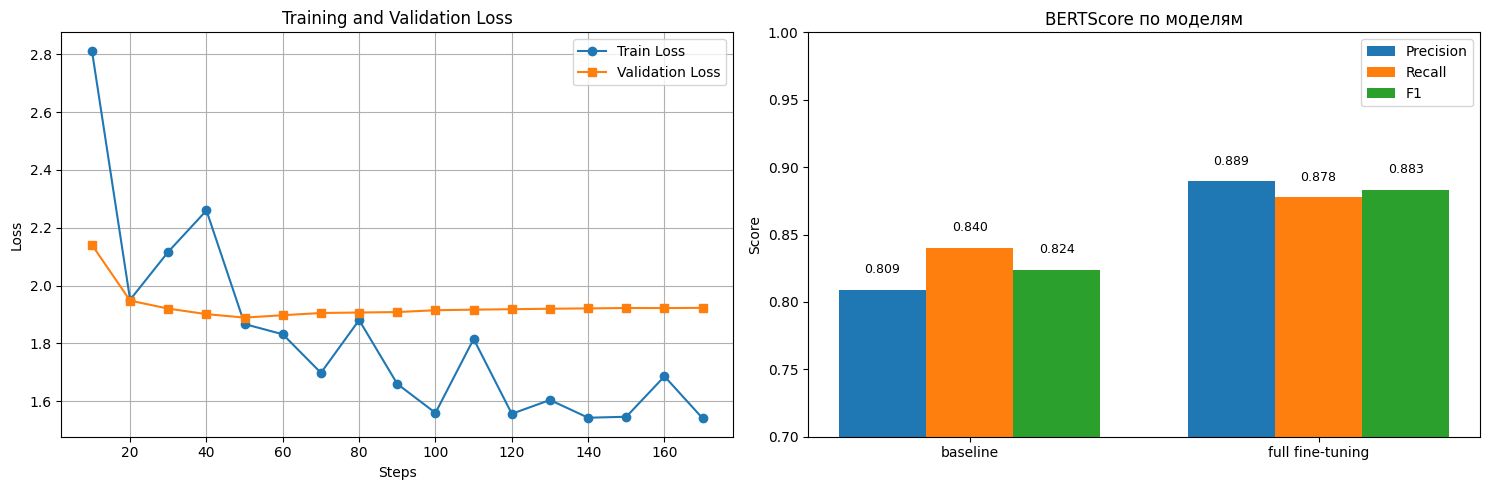

In [12]:

bertscore_dicts = [
    baseline_metrics,
    full_fine_tuning_metrics
   # {"model": "Baseline", "precision": 0.82, "recall": 0.80, "f1": 0.81},
   # {"model": "Finetuned", "precision": 0.84, "recall": 0.83, "f1": 0.84},
   # {"model": "QLoRA", "precision": 0.85, "recall": 0.83, "f1": 0.84}
]
plot_training_and_bertscore(metrics_callback, bertscore_dicts)

In [13]:

# 14. Пример инференса
test_prompt = "Question: What is a healthy breakfast?\nContext: Oatmeal with fruits and nuts provides a balanced breakfast.\nAnswer:"
inputs = tokenizer(test_prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=64, no_repeat_ngram_size=2, repetition_penalty=1.2)
print("\n=== Sample prediction ===")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


=== Sample prediction ===
Question: What is a healthy breakfast?
Context: Oatmeal with fruits and nuts provides a balanced breakfast.
Answer: A light, nutritious meal that contains at least one source of protein.


In [15]:
# Освобождаем память
del model
del baseline_model
torch.cuda.empty_cache()